In [1]:
%load_ext autoreload

%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session
from spikeA.Dat_file_reader import Dat_file_reader
from spikeA.Intervals import Intervals
from spikeA.Spike_train import Spike_train
from spikeA.Spike_waveform import Spike_waveform
from spikeA.ttl import detectTTL
from tqdm import tqdm
import os.path
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import spikeA.spatial_properties
import re

In [2]:
mouse="bt1123"
date="09012022"
name=f"{mouse}-{date}-0107"
path=f"/adata/electro/{mouse}/{name}/"

Check the files

## Get a Session object and load spikes

In [3]:
ses = Kilosort_session(name=name,path=path)
ses.load_parameters_from_files()
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
cg = Cell_group(stl)

## Create a pose file 

In [4]:
ap = Animal_pose(ses)
if not os.path.exists(f"{ses.fileBase}.pose.npy"):
    ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50,extension="positrack")
    ap.save_pose_to_file() # save the file for next time
else:
    ap.load_pose_from_file()

## Limit analysis to a particular trial and identify the stimulation trial

You can get the time intervals for each trial from the session object.

* Get the time at which each trial starts and ends
* Set the intervals in the spike train object. 
* Set the intervals in the animal_pose object. 

In [5]:
first_trial_inter = ses.trial_intervals.inter[0:1,:] # baseline
second_trial_inter = ses.trial_intervals.inter[2:3,:] # novel environment or object_loc1
third_trial_inter = ses.trial_intervals.inter[4:5,:] # baseline_re or object_loc2
forth_trial_inter = ses.trial_intervals.inter[6:7,:] # stim_trial or object_loc1

if re.search('0109$', str(name)):
    fifth_trial_inter = ses.trial_intervals.inter[8:9,:] # stim_trial

stim_trial = [i for i, j in enumerate(ses.stimulation) if j == 'MS'][0]
print("Stim trial:", stim_trial+1) #counting the first trial as trial 1

Stim trial: 7


Read the dat file to get the time points of laser pulses. Save the result in a file.

In [6]:
up_file_name = ses.path + "/" + ses.trial_names[stim_trial] + ".stim_ups_sec.npy"
if not os.path.exists(up_file_name):
    dat_file_name = ses.path + "/" + ses.trial_names[stim_trial]+".dat"
    print(dat_file_name)
    df = Dat_file_reader(file_names=[dat_file_name],n_channels = ses.n_channels)
    laser_channel_data = df.get_data_one_block(0,df.files_last_sample[-1],np.array([ses.n_channels-2]))
    ups,downs = detectTTL(ttl_data = laser_channel_data)
    print("Number of laser pulses detected: {}".format(ups.shape[0]))
    #need to add the time that has passed before the stim trial
    ups = ups/ses.sampling_rate + ses.trial_intervals.inter[stim_trial:stim_trial+1,0] # intervals in seconds
    np.save(file = up_file_name, arr = ups)
else:
    ups = np.load(up_file_name)

Get the laser frequency.

In [7]:
laser_intervals = np.diff(ups)
stim_freq = 1/np.nanmean(laser_intervals)
print(f"Laser frequency: {stim_freq} Hz")

Laser frequency: 8.023701086299791 Hz


Plot the crosscorrelation between the laser pulses and the spikes of a cell.

Text(0, 0.5, 'Spike count')

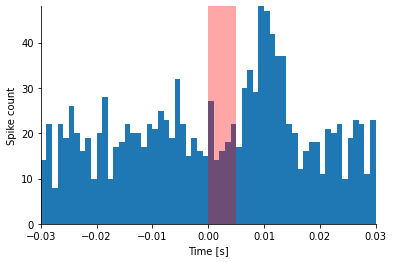

In [8]:
min_sec=-0.03; max_sec=0.03; bin_size_sec=0.001
n = cg.neuron_list[13]

n.spike_train.set_intervals(ses.trial_intervals.inter[stim_trial:stim_trial+1,:])
hist,edges = n.spike_train.spike_time_crosscorrelation(st1=ups, st2=n.spike_train.st, bin_size_sec=bin_size_sec, min_sec=min_sec, max_sec=max_sec)
timestamp = n.spike_train.mid_point_from_edges(edges)

#plot
fig,ax = plt.subplots()
ax.bar(timestamp, hist, width=bin_size_sec)     
laser_pulse = ax.bar(0,np.max(hist),width=0.005, align='edge', color='red', alpha=0.35)
ax.set_xlim(min_sec, max_sec)
ax.set_ylim(0,np.max(hist))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Spike count")